In [1]:
import sys
sys.path.insert(1, './wlcstat/')
import numpy as np
import scipy.special as sp
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns

In [2]:
def eval_f_bind_competitive(n_b_arr, n_m, e_m_arr,\
                        j_int_g1g1, j_int_g1g2, j_int_g2g2):
    r"""
    eval_f_bind - Evaluate the binding free energy
    
    Parameters
    ----------
    n_b : integer
        Number of reader proteins bound to the nucleosome
    n_m : integer
        Number of marked tails
    e_me3 : float
        Favorable binding free energy to tri-methylated tails
        
    Returns
    -------
    f_bind : float
        Binding free energy
    
    """
    # Calculate the cases for the binding free energy
    f_bind = 0
    
    if n_b_arr==[0,0]:
        f_bind = 0
    elif n_b_arr==[1,0]:
        if n_m == 0:
            f_bind = -np.log(2)
        elif n_m == 1:
            f_bind = -np.log(np.exp(-e_m_arr[0]) + 1)
        elif n_m == 2:
            f_bind = -np.log(2) + e_m_arr[0]
    elif n_b_arr==[0,1]:
        if n_m == 0:
            f_bind = -np.log(2)
        elif n_m == 1:
            f_bind = -np.log(np.exp(-e_m_arr[1]) + 1)
        elif n_m == 2:
            f_bind = -np.log(2) + e_m_arr[1]
    elif n_b_arr==[1,1]:
        if n_m == 0:
            f_bind = -np.log(2)+j_int_g1g2
        elif n_m == 1:
            f_bind = -np.log(np.exp(-e_m_arr[0]) + np.exp(-e_m_arr[1]))+j_int_g1g2
        elif n_m == 2:
            f_bind = -np.log(2) + e_m_arr[0] + e_m_arr[1]+j_int_g1g2
    elif n_b_arr==[2,0]:
        if n_m == 0:
            f_bind = 0+j_int_g1g1
        elif n_m == 1:
            f_bind = e_m_arr[0]+j_int_g1g1
        elif n_m == 2:
            f_bind = 2*e_m_arr[0]+j_int_g1g1
    elif n_b_arr==[0,2]:
        if n_m == 0:
            f_bind = 0+j_int_g2g2
        elif n_m == 1:
            f_bind = e_m_arr[1]+j_int_g2g2
        elif n_m == 2:
            f_bind = 2*e_m_arr[1]+j_int_g2g2
            
    
    return f_bind

def eval_f_bind_competitive_arr(n_b_arr, n_m_arr, e_m_arr,\
                        j_int_g1g1, j_int_g1g2, j_int_g2g2):
    r"""
    eval_f_bind - Evaluate the binding free energy
    
    Parameters
    ----------
    n_b : integer
        Number of reader proteins bound to the nucleosome
    n_m : integer
        Number of marked tails
    e_me3 : float
        Favorable binding free energy to tri-methylated tails
        
    Returns
    -------
    f_bind : float
        Binding free energy
    
    """
    # Calculate the cases for the binding free energy
    f_bind_arr = np.zeros(len(n_m_arr))
    
    for i,n_m in enumerate(n_m_arr):
        if n_b_arr==[0,0]:
            f_bind = 0
        elif n_b_arr==[1,0]:
            if n_m == 0:
                f_bind = -np.log(2)
            elif n_m == 1:
                f_bind = -np.log(np.exp(-e_m_arr[0]) + 1)
            elif n_m == 2:
                f_bind = -np.log(2) + e_m_arr[0]
        elif n_b_arr==[0,1]:
            if n_m == 0:
                f_bind = -np.log(2)
            elif n_m == 1:
                f_bind = -np.log(np.exp(-e_m_arr[1]) + 1)
            elif n_m == 2:
                f_bind = -np.log(2) + e_m_arr[1]
        elif n_b_arr==[1,1]:
            if n_m == 0:
                f_bind = -np.log(2)+j_int_g1g2
            elif n_m == 1:
                f_bind = -np.log(np.exp(-e_m_arr[0]) + np.exp(-e_m_arr[1]))+j_int_g1g2
            elif n_m == 2:
                f_bind = -np.log(2) + e_m_arr[0] + e_m_arr[1]+j_int_g1g2
        elif n_b_arr==[2,0]:
            if n_m == 0:
                f_bind = 0+j_int_g1g1
            elif n_m == 1:
                f_bind = e_m_arr[0]+j_int_g1g1
            elif n_m == 2:
                f_bind = 2*e_m_arr[0]+j_int_g1g1
        elif n_b_arr==[0,2]:
            if n_m == 0:
                f_bind = 0+j_int_g2g2
            elif n_m == 1:
                f_bind = e_m_arr[1]+j_int_g2g2
            elif n_m == 2:
                f_bind = 2*e_m_arr[1]+j_int_g2g2

        f_bind_arr[i] = f_bind
    return f_bind_arr

def find_zero_crossings(matrix):
    zero_crossings = np.where(np.diff(np.signbit(matrix)))
    zero_crossings_vert = np.where(np.diff(np.signbit(matrix), axis=0))
    crossings = np.array(list(zip(zero_crossings[0], zero_crossings[1]))+ list(zip(zero_crossings_vert[0], zero_crossings_vert[1])))
    return crossings

import time

def calc_saddle_point_E(f_bars, phi_c, v_int, mu, poly_marks, e_m, f_binds):
    # For two protein types, calculates the part of saddle point free energy that changes when the 
    # average binding state changes
    # f_gammas: list of the two average binding fractions, one for each protein type

    
    # calc mean-field protein-protein interaction
#     print("f_bars:", f_bars)
    mf_pp_int = 0.5*phi_c**2
    for g1 in range(len(f_bars)):
        for g2 in range(len(f_bars)):
            mf_pp_int += v_int[g1][g2]*f_bars[g1]*f_bars[g2]
#     print(" mean-field protein-protein interaction: ", mf_pp_int)
    # calc binding partition function

    phi_bind_arr = phi_c * np.array(f_bars)
#             erg_int = np.matmul(v_int, phi_bind_arr)
    erg_int = np.matmul(phi_bind_arr, v_int)
    
    coef1 = -erg_int[0] + mu[0] 
    coef2 = -erg_int[1] + mu[1]    
    
#     f_bind_g1_s1 = eval_f_bind_vec(1, poly_marks[0], e_m[0], v_int[0,0])
#     f_bind_g1_s2 = eval_f_bind_vec(2, poly_marks[0], e_m[0], v_int[0,0])
#     f_bind_g2_s1 = eval_f_bind_vec(1, poly_marks[1], e_m[1], v_int[1,1])
#     f_bind_g2_s2 = eval_f_bind_vec(2, poly_marks[1], e_m[1], v_int[1,1])
    
#     gam1_part = np.sum(np.log(1 + np.exp(coef1 - f_bind_g1_s1) + np.exp(2*coef1 - f_bind_g1_s2)))
#     gam2_part = np.sum(np.log(1 + np.exp(coef2 - f_bind_g2_s1) + np.exp(2*coef2 - f_bind_g2_s2)))
    
#     bind_part = phi_c*(gam1_part + gam2_part)    
    [P10_fbind, P01_fbind, P20_fbind, P02_fbind, P11_fbind] = f_binds
    P00= 1
    P10= np.exp(mu[0] - erg_int[0] \
                - P10_fbind)
    P01= np.exp(mu[1] - erg_int[1] \
                - P01_fbind)
    P20= np.exp(2*mu[0] - 2*erg_int[0] \
                - P20_fbind)
    P02= np.exp(2*mu[1] - 2*erg_int[1] \
                - P02_fbind)
    P11= np.exp(mu[0] - erg_int[0] + mu[1] - erg_int[1] \
                - P11_fbind)

    q = P00 + P10 + P01 + P20 + P02 + P11    
    
    bind_part = phi_c * np.sum(q)

    return -1 * (mf_pp_int + bind_part)

# def calc_saddle_point_E(f_bars, phi_c, v_int, mu, poly_marks, e_m):
#     # For two protein types, calculates the part of saddle point free energy that changes when the 
#     # average binding state changes
#     # f_gammas: list of the two average binding fractions, one for each protein type

#     start = time.process_time()
#     # calc mean-field protein-protein interaction
# #     print("f_bars:", f_bars)
#     mf_pp_int = 0.5*phi_c**2
#     for g1 in range(len(f_bars)):
#         for g2 in range(len(f_bars)):
#             mf_pp_int += v_int[g1][g2]*f_bars[g1]*f_bars[g2]
# #     print(" mean-field protein-protein interaction: ", mf_pp_int)
#     # calc binding partition function

#     phi_bind_arr = phi_c * np.array(f_bars)
# #             erg_int = np.matmul(v_int, phi_bind_arr)
#     erg_int = np.matmul(phi_bind_arr, v_int)
    
#     coef1 = -erg_int[0] + mu[0] 
#     coef2 = -erg_int[1] + mu[1]    
    
# #     f_bind_g1_s1 = eval_f_bind_vec(1, poly_marks[0], e_m[0], v_int[0,0])
# #     f_bind_g1_s2 = eval_f_bind_vec(2, poly_marks[0], e_m[0], v_int[0,0])
# #     f_bind_g2_s1 = eval_f_bind_vec(1, poly_marks[1], e_m[1], v_int[1,1])
# #     f_bind_g2_s2 = eval_f_bind_vec(2, poly_marks[1], e_m[1], v_int[1,1])
    
# #     gam1_part = np.sum(np.log(1 + np.exp(coef1 - f_bind_g1_s1) + np.exp(2*coef1 - f_bind_g1_s2)))
# #     gam2_part = np.sum(np.log(1 + np.exp(coef2 - f_bind_g2_s1) + np.exp(2*coef2 - f_bind_g2_s2)))
    
# #     bind_part = phi_c*(gam1_part + gam2_part)
#     bef = time.process_time()
#     print("before bind part")
#     print(bef - start)    

#     P00= 1
#     P10= np.exp(mu[0] - erg_int[0] \
#                 - eval_f_bind_competitive_arr([1,0] , poly_marks[0], e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#     P01= np.exp(mu[1] - erg_int[1] \
#                 - eval_f_bind_competitive_arr([0,1] , poly_marks[0], e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#     P20= np.exp(2*mu[0] - 2*erg_int[0] \
#                 - eval_f_bind_competitive_arr([2,0] , poly_marks[0], e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#     P02= np.exp(2*mu[1] - 2*erg_int[1] \
#                 - eval_f_bind_competitive_arr([0,2] , poly_marks[0], e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#     P11= np.exp(mu[0] - erg_int[0] + mu[1] - erg_int[1] \
#                 - eval_f_bind_competitive_arr([1,1] , poly_marks[0], e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))

#     q = P00 + P10 + P01 + P20 + P02 + P11    
    
#     bind_part = phi_c * np.sum(q)
#     aft = time.process_time()
#     print("after bind part")
#     print(aft - bef)
#     print("--------------------------------------------------")
#     return -1 * (mf_pp_int + bind_part)

In [3]:
# need to produce rank 2 tensor that, given two protein types, 
# find avg of product of s for index ij
def eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, gam1_ind, gam2_ind):
    '''
    poly marks (array of arrays) contains an array of marks per nucleosome for each protein type
    gam1_ind (int) is the index of first protein
    gam2_ind (int) is the index of second protein
    '''
    
    n_bind = len(mu)
    # evaluate eqn 85 for each index ij
 
    phi_bind = phi_c * np.array(f_bars)

    erg_int = np.matmul(phi_bind, v_int) #sum over gamma 2 of int and phi and f

    coef1 = -erg_int[gam1_ind] + mu[gam1_ind] 
    coef2 = -erg_int[gam2_ind] + mu[gam2_ind]
    
#     coef1 = -erg_int[gam1_ind] + mu[gam2_ind] 
#     coef2 = -erg_int[gam2_ind] + mu[gam1_ind]
    
    #make vector form of f_bind
    f_bind_g1_s1 = eval_f_bind_vec(1, poly_marks[gam1_ind], e_m[gam1_ind], v_int[gam1_ind,gam1_ind])
    f_bind_g1_s2 = eval_f_bind_vec(2, poly_marks[gam1_ind], e_m[gam1_ind], v_int[gam1_ind,gam1_ind])
    f_bind_g2_s1 = eval_f_bind_vec(1, poly_marks[gam2_ind], e_m[gam2_ind], v_int[gam2_ind,gam2_ind])
    f_bind_g2_s2 = eval_f_bind_vec(2, poly_marks[gam2_ind], e_m[gam2_ind], v_int[gam2_ind,gam2_ind])
    
    #combine coef and f_bind to create 4 dif energies needed
#     - each should be rank 2 tensors
    
    exp_g1_s1 = np.exp(coef1 - f_bind_g1_s1)  #energy at each nucleosome if one gamma 1 protein bound
    exp_g1_s2 = np.exp(2*coef1 - f_bind_g1_s2)
    exp_g2_s1 = np.exp(coef2 - f_bind_g2_s1)
    exp_g2_s2 = np.exp(2*coef2 - f_bind_g2_s2)
    
    exp_11 = np.outer(exp_g1_s1, exp_g2_s1) #getting combined probability at each nucleosome pair
    exp_12 = np.outer(exp_g1_s1, exp_g2_s2)
    exp_21 = np.outer(exp_g1_s2, exp_g2_s1)
    exp_22 = np.outer(exp_g1_s2, exp_g2_s2)
    
    #  (0,0)                (1,0)                                      (0,1)
    q = 1 + np.outer(exp_g1_s1, np.ones(len(exp_g1_s1))) + np.outer(exp_g2_s1, np.ones(len(exp_g1_s1))).T\
    + np.outer(exp_g1_s2,np.ones(len(exp_g1_s1))) + np.outer(exp_g2_s2, np.ones(len(exp_g1_s1))).T\
    + (exp_11 + exp_12 + exp_21 + exp_22) 
    #calculate average matrix (eq 85)
    sisj_bind = (exp_11 + 2*exp_12 + 2*exp_21 + 4*exp_22) / q
    return sisj_bind 


In [17]:
marks_1 = np.loadtxt(r"C:\Users\tmhab\Downloads\H3K9me3_ENCFF651ZTT_Chr_22_trimmed.txt").astype(np.uint8)

n_bind = 2 #types of proteins/marks

# fraction of nucleosomes with 0,1,2 marks per protein type, calculated form marks1: 
f_om = np.array([(np.array(marks_1)==0).sum(),(np.array(marks_1)==1).sum(),(np.array(marks_1)==2).sum(), \
                    (np.array(marks_1)==0).sum(),(np.array(marks_1)==1).sum(),(np.array(marks_1)==2).sum()])/len(marks_1)
poly_marks = [marks_1, marks_1]

# e_m = np.array([-1.5, -1.5]) #binding energy
e_m = np.array([-2, -2]) #binding energy
# e_m = np.array([0,-1.5]) #binding energy

# f_om = np.array([1/3, 1/3, 1/3, 1/3, 1/3, 1/3]) # fraction of nucleosomes with 0,1,2 marks per protein type

v_int = np.array([[-3.92, 3.0],[3.0, -3.92]])
# v_int = np.array([[-3.92,0],[0,-3.92]]) # protein-protein interaction param
# v_int = np.array([[-1.,0],[0,0]]) # protein-protein interaction param
# v_int = np.array([[0,0],[0,0]]) # protein-protein interaction param
phi_c = 0.6# avg amount of chromosome 

# x = np.zeros(n_bind * 3)

l_p = 53 # 53 nm
bp_p_b = 45 # base pairs per bond
nm_p_bp = 0.34 # nanometetrs per base pair
b = l_p * 2 #kuhn length

N = (len(marks_1)-1) * bp_p_b * nm_p_bp * (1/b)
N_m = N/(len(marks_1)-1)


# b = 1
# N_m = 1000
# N = N_m * len(marks_1)
print(N)

36647.974528301886


In [18]:
%%time

# faster? 

# TWO PROTEIN TYPES
#TODO: 
#  - deal with multiple solutions (currently, just choosing minimum soln)

#denisty map setting
mu1_array = np.arange(-10, 10, 0.5)#[-5]
mu2_array = np.arange(-10, 10, 0.5)#[-5]
f_gam_arr = np.arange(-0.01,2.02,0.01)

# mu1_array = np.arange(-10, 10, 1)#[-5]
# mu2_array = np.arange(-10, 10, 1)#[-5]
# f_gam_arr = np.arange(-0.1,2.2,0.1)
#1d plot settings
# mu1_array = np.arange(-10, 10, 0.01)#[-5]
# mu2_array = np.arange(-10, 10, 0.01)#[-5]
# f_gam_arr = np.arange(-0.005,2.02,0.001)

# f_gam_arr = np.arange(-0.25,2.26,0.25)
f_gam_soln_arr = np.zeros((n_bind, len(mu1_array), len(mu2_array)))

s_bind_soln_arr = np.zeros((n_bind*3, len(mu1_array), len(mu2_array)))

f_gam_soln_arr_max = np.zeros((n_bind, len(mu1_array), len(mu2_array)))
f_gam_soln_arr_min = np.zeros((n_bind, len(mu1_array), len(mu2_array)))

multi_soln_mus = np.zeros((len(mu1_array), len(mu2_array)))

P10_fbind = eval_f_bind_competitive_arr([1,0] , poly_marks[0], e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
P01_fbind = eval_f_bind_competitive_arr([0,1] , poly_marks[0], e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
P20_fbind = eval_f_bind_competitive_arr([2,0] , poly_marks[0], e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
P02_fbind = eval_f_bind_competitive_arr([0,2] , poly_marks[0], e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
P11_fbind = eval_f_bind_competitive_arr([1,1] , poly_marks[0], e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_binds = [P10_fbind, P01_fbind, P20_fbind, P02_fbind, P11_fbind]
        
for k, mu1 in enumerate(mu1_array):
    for l, mu2 in enumerate(mu2_array):
        mu = [mu1, mu2]

#         print(mu)

        # 1) generate right hand side (RHS) of f_gamma1 and f_gamma2 as 2d matrices ( [f1, f2] )


        phi_bind_arr = np.zeros(len(f_gam_arr))
        phi_bind_arr = phi_c * f_gam_arr

        RHS = np.zeros(len(f_gam_arr))
        RHS_arr = np.zeros((n_bind, len(f_gam_arr),len(f_gam_arr)))

        f1,f2 = np.meshgrid(f_gam_arr,f_gam_arr)
        combined_matrix = np.dstack((f1*phi_c, f2*phi_c))#.tolist()
        erg_int = np.einsum('kl,ijk->jil', v_int, combined_matrix)  #WORKS this is the mat mul of each fgamma pair

        erg_ints = np.split(erg_int, n_bind, axis=2)
        for i in range(len(erg_ints)):
            erg_ints[i] = np.squeeze(erg_ints[i])

#         for mark in range(n_bind): # for each reader protein/ mark type
        for om in range(3): 
            ## 00, 01, 10, 11, 20, 02
            P00= 1
            P10= np.exp(mu[0] - erg_ints[0] \
                        - eval_f_bind_competitive([1,0] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
            P01= np.exp(mu[1] - erg_ints[1] \
                        - eval_f_bind_competitive([0,1] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
            P20= np.exp(2*mu[0] - 2*erg_ints[0] \
                        - eval_f_bind_competitive([2,0] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
            P02= np.exp(2*mu[1] - 2*erg_ints[1] \
                        - eval_f_bind_competitive([0,2] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
            P11= np.exp(mu[0] - erg_ints[0] + mu[1] - erg_ints[1] \
                        - eval_f_bind_competitive([1,1] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
            
            q = P00 + P10 + P01 + P20 + P02 + P11
            sg1_avg_raw = 0*P00 + 1*P10 + 0*P01 + 2*P20 + 0*P02 + 1*P11
            sg2_avg_raw = 0*P00 + 0*P10 + 1*P01 + 0*P20 + 2*P02 + 1*P11
#             q = 1 + np.exp(mu[mark] - f_bind_1 - erg_ints[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_ints[mark])
            
            mark = 0
            RHS = RHS_arr[mark] 

            RHS += f_om[om+(mark*3)] * sg1_avg_raw / q 
            RHS_arr[mark] = RHS
            
            mark = 1
            RHS = RHS_arr[mark] 

            RHS += f_om[om+(mark*3)] * sg2_avg_raw / q 
            RHS_arr[mark] = RHS           


        # 2) self-consistently solve for fgamma1 and fgamma2, finding where the difference (fgamma-RHS) crosses zero




        X, Y = np.meshgrid(f_gam_arr, f_gam_arr)

        crs1 = find_zero_crossings(RHS_arr[0]-Y)
        crs2 = find_zero_crossings(RHS_arr[1]-X)


        # 3) find the intersection of the sets of fgamma_n solutions, such that both f_gammas are self consistent

        
        aset = set([tuple(x) for x in crs1])
        bset = set([tuple(x) for x in crs2])
        inds = np.array([x for x in aset & bset])+1

        f_gam_solns = np.zeros(len(inds), dtype = "object")#f_gam_arr[inds[0]]
        min_soln = [-1]*n_bind
        min_E_soln = [None]*n_bind
        min_E = None

        for i in range(len(inds)):
#             # TODO implement interpolation for each solution, only in vicinity (essentially redo entire analysis)
#             # for each point, get an array of all neighboring points (x,y) and at those points RHS - Y, RHS - X (z)

            #original solution
            soln = f_gam_arr[inds[i]]           
#             f_gam_solns[i] = soln
            
            # choosing solution with min free energy
            
            if len(inds) == 1:
                min_E_soln = soln
            else:
                E_soln = calc_saddle_point_E(soln, phi_c, v_int, mu, poly_marks, e_m, f_binds)
                if min_E == None:
                    min_E_soln = soln
                    min_E = E_soln

                else:
                    if E_soln < min_E:
                        min_E_soln = soln
                        min_E = E_soln
        multi_soln = False
        if len(f_gam_solns) > 1:
            multi_soln_mus[k,l] = 1

        f_gam_solns = [min_E_soln] # selecting minimum E solution


        # 4) for each f_gamma solution pair, calculate each individual s_bind (omega = 0-2)


        sbind = np.zeros((len(f_gam_solns), n_bind*3))

        for j, f_gam_soln in enumerate(f_gam_solns):
            phi_bind_arr = phi_c * np.array(f_gam_soln)
            erg_int = np.matmul(v_int, phi_bind_arr)

#             ind = 0
#             for mark in range(n_bind): # for each reader protein/ mark type
#                 for om in range(3): # for each possible number of marked tails on nucl
#                     f_bind_1 = eval_f_bind_competitive(1, om, e_m[mark], v_int[mark, mark])
#                     f_bind_2 = eval_f_bind_competitive(2, om, e_m[mark], v_int[mark, mark])
#                     q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])

#                     sbind[j, om+mark*3] =  (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
#                                                  2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q 
#                     ind+=1    
#                 ind0 = mark * 3 
                
            for om in range(3): 
                ## 00, 01, 10, 11, 20, 02
                P00= 1
                P10= np.exp(mu[0] - erg_int[0] \
                            - eval_f_bind_competitive([1,0] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
                P01= np.exp(mu[1] - erg_int[1] \
                            - eval_f_bind_competitive([0,1] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
                P20= np.exp(2*mu[0] - 2*erg_int[0] \
                            - eval_f_bind_competitive([2,0] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
                P02= np.exp(2*mu[1] - 2*erg_int[1] \
                            - eval_f_bind_competitive([0,2] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
                P11= np.exp(mu[0] - erg_int[0] + mu[1] - erg_int[1] \
                            - eval_f_bind_competitive([1,1] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))

                q = P00 + P10 + P01 + P20 + P02 + P11
                sg1_avg_raw = 0*P00 + 1*P10 + 0*P01 + 2*P20 + 0*P02 + 1*P11
                sg2_avg_raw = 0*P00 + 0*P10 + 1*P01 + 0*P20 + 2*P02 + 1*P11
    #             q = 1 + np.exp(mu[mark] - f_bind_1 - erg_ints[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_ints[mark])

                mark = 0
                sbind[j, om+mark*3] =  sg1_avg_raw / q 

                mark = 1
                sbind[j, om+mark*3] =  sg2_avg_raw / q 
        #         print("self-consistency test")
        #         print(np.sum(f_om[ind0:(ind0 + 3)] * sbind[j][ind0:(ind0 + 3)]))
        #         print(f_gam_solns[j][mark])
        
        # 4) store results in array
        # TODO: figure out how to handle mwhen multiple solutions to f_gam
        # current method is to choose minimum solution
        
        if multi_soln:
            raise Exception("not implemented")
            for f_gam_soln in f_gam_solns:
                for mark in range(n_bind):
                    f_gam_soln_arr_max[mark][k][l] = ""
        else:
            for mark in range(n_bind): 
                f_gam_soln_arr[mark][k][l] = f_gam_solns[0][mark]
                for om in range(3):
                    s_bind_soln_arr[om+mark*3][k][l] = sbind[0,om+mark*3]


# KEY RETURNS: f_gam_soln_arr, list of matrices of self-consistent f_gammas (for protein 1 and 2) at each mu1, mu2
#              s_bind_soln_arr, list of matrices of s_binds at each mu1, mu2

CPU times: total: 49.6 s
Wall time: 1min 49s


Text(0.5, 1.0, 'multiple soln indices')

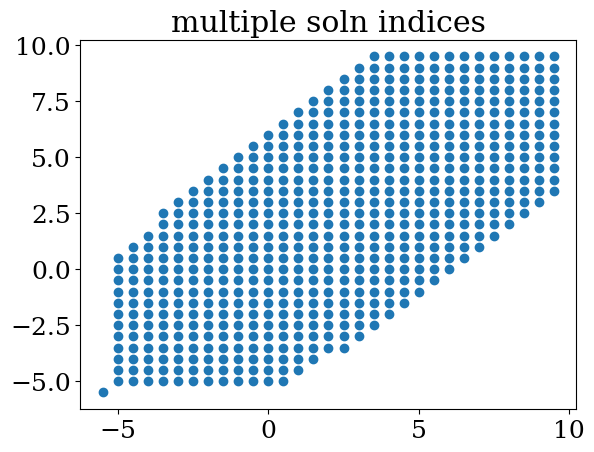

In [19]:
## mu values where multiple solutions exist. choosing minimum one
plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
plt.title("multiple soln indices")

<Figure size 640x480 with 0 Axes>

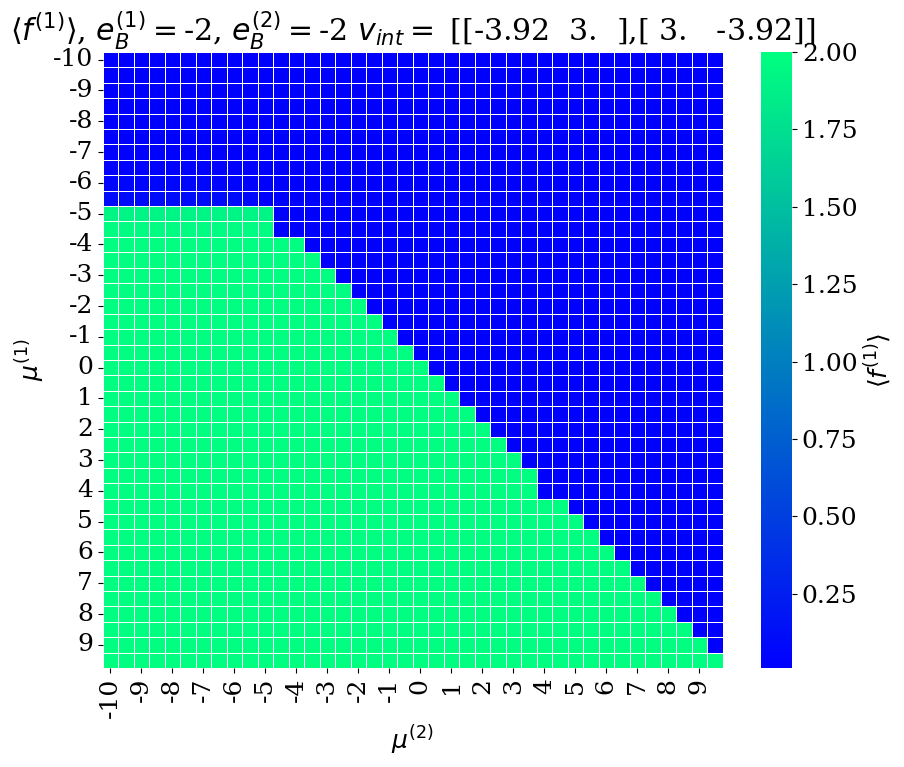

In [20]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])

#protein 1
ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
          str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
          +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")

#protein 2
# ax = sns.heatmap(f_gam_soln_arr[1], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(2)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(2)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")

plt.show()


<Figure size 640x480 with 0 Axes>

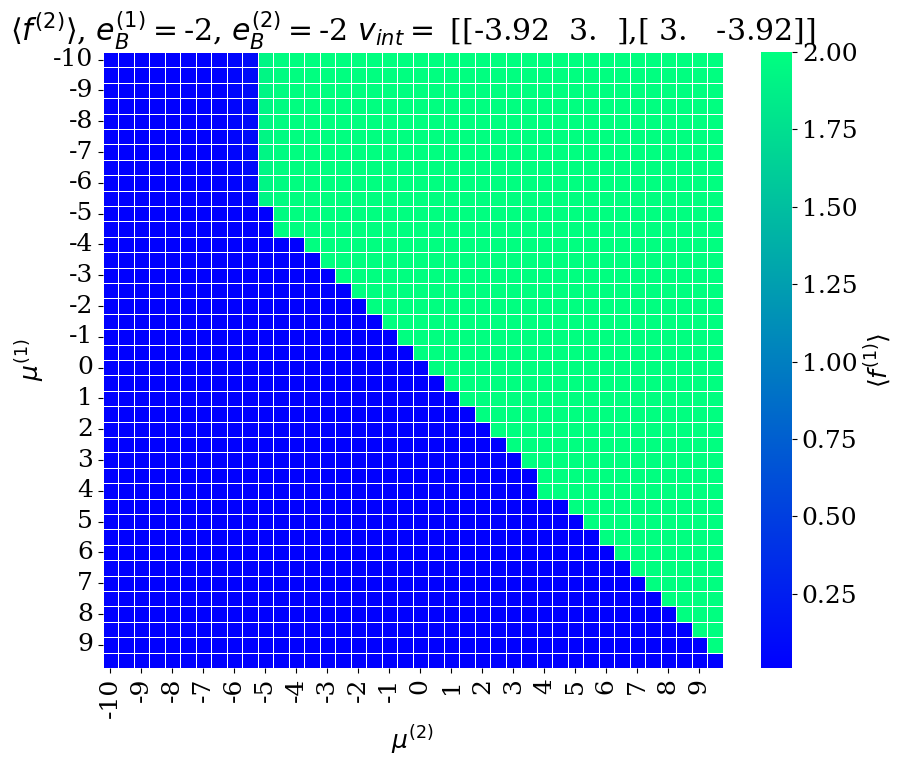

In [21]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])

#protein 1
ax = sns.heatmap(f_gam_soln_arr[1], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ \langle f^{(2)} \rangle $" +  ", $e_B^{(1)} = $" + \
          str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
          +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")

#protein 2
# ax = sns.heatmap(f_gam_soln_arr[1], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(2)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(2)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")

plt.show()


<Figure size 640x480 with 0 Axes>

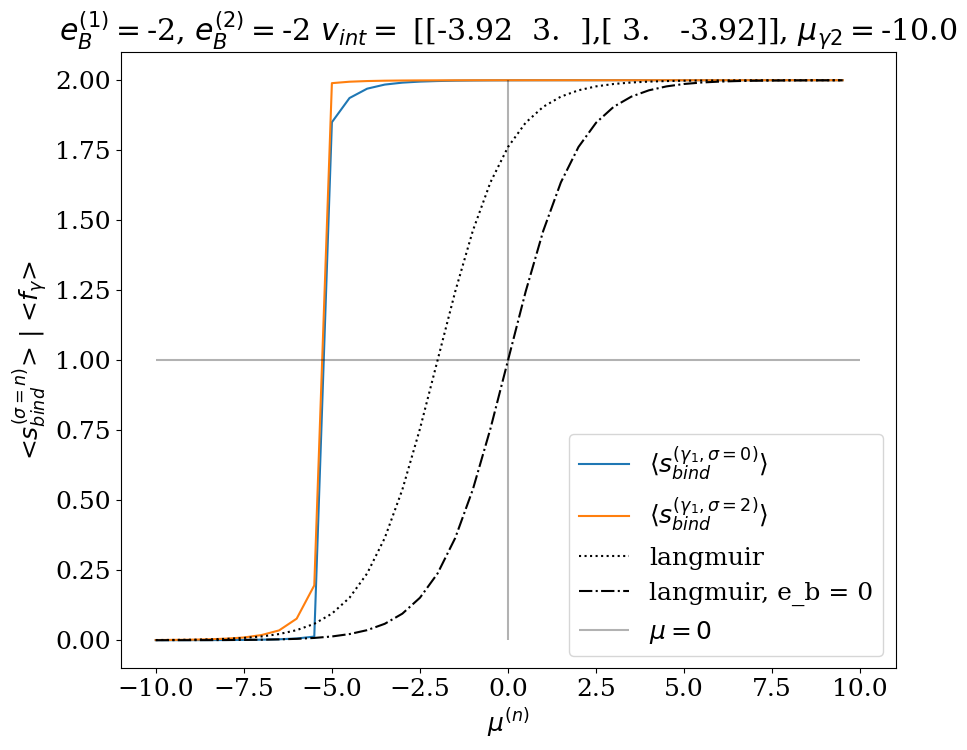

In [22]:
# 1D solution plotting
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
    

# # f_bar (single solns ONLY): 
# plt.plot(mu1_array, f_gam_soln_arr[0][:,9], label = r"$ \langle f_{\gamma}^{(1)} \rangle $", color = "blue")
# plt.plot(mu2_array, f_gam_soln_arr[1][6,:], label = r"$ \langle f_{\gamma}^{(2)} \rangle $", color = "green", linestyle = "--")

mu_int = 0
# s_bind:
plt.plot(mu1_array, s_bind_soln_arr[0][:,mu_int], label = r"$ \langle s_{bind}^{(\gamma_1, \sigma = 0)} \rangle $",)
# plt.plot(mu1_array, s_bind_soln_arr[1][:,0], label = r"$ \langle s_{bind}^{(\gamma_1, \sigma = 1)} \rangle $",)
plt.plot(mu1_array, s_bind_soln_arr[2][:,mu_int], label = r"$ \langle s_{bind}^{(\gamma_1, \sigma = 2)} \rangle $",)


# plt.plot(mu2_array, s_bind_soln_arr[3][0,:], label = r"$ \langle s_{bind}^{(\gamma_2, \sigma = 0)} \rangle $",)
# plt.plot(mu2_array, s_bind_soln_arr[4][0,:], label = r"$ \langle s_{bind}^{(\gamma_2, \sigma = 1)} \rangle $",)
# plt.plot(mu2_array, s_bind_soln_arr[5][0,:], label = r"$ \langle s_{bind}^{(\gamma_2, \sigma = 2)} \rangle $",)


# LANGMUIR. Assumptions only valid when v_int = 0, and for sigma =0 or 2 (all sites identical)
K = np.exp(-e_m[0])
plt.plot(mu1_array, 2*K*np.exp(mu1_array) / (1+ K*np.exp(mu1_array)), label = "langmuir", linestyle = ":", color = "black")

K = np.exp(-0)  # sigma = 0 - all binding energies are 0
plt.plot(mu1_array, 2*K*np.exp(mu1_array) / (1+ K*np.exp(mu1_array)), label = "langmuir, e_b = 0", linestyle = "-.", color = "black")


plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
plt.xlabel("$\mu^{(n)} $")
plt.title(r"$e_B^{(1)} = $" + \
          str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
          +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "], $\mu_{\gamma2} =$" +str(mu2_array[mu_int]))
plt.hlines(1, -10, 10, color = "black", alpha = 0.3)
# plt.vlines(-.75, 0,2, color = "black", alpha = 0.3, label = "$\mu = -0.75$")
plt.vlines(-0, 0,2, color = "black", alpha = 0.3, label = "$\mu = 0$")
plt.legend()

# why is s_bind = 2 * (exp(x \ (1 + exp)))? how did that realtion come about. it is to allow for unbounded minimizationq
#check solver- intial conditions? 

In [6]:
# SLOW saddl epoint E
# %%time
# # TWO PROTEIN TYPES
# #TODO: 
# #  - deal with multiple solutions (currently, just choosing minimum soln)

# #denisty map setting
# mu1_array = np.arange(-10, 10, 0.5)#[-5]
# mu2_array = np.arange(-10, 10, 0.5)#[-5]
# f_gam_arr = np.arange(-0.01,2.02,0.01)

# mu1_array = np.arange(-10, 10, 1)#[-5]
# mu2_array = np.arange(-10, 10, 1)#[-5]
# f_gam_arr = np.arange(-0.1,2.2,0.1)
# #1d plot settings
# # mu1_array = np.arange(-10, 10, 0.01)#[-5]
# # mu2_array = np.arange(-10, 10, 0.01)#[-5]
# # f_gam_arr = np.arange(-0.005,2.02,0.001)

# # f_gam_arr = np.arange(-0.25,2.26,0.25)
# f_gam_soln_arr = np.zeros((n_bind, len(mu1_array), len(mu2_array)))

# s_bind_soln_arr = np.zeros((n_bind*3, len(mu1_array), len(mu2_array)))

# f_gam_soln_arr_max = np.zeros((n_bind, len(mu1_array), len(mu2_array)))
# f_gam_soln_arr_min = np.zeros((n_bind, len(mu1_array), len(mu2_array)))

# multi_soln_mus = np.zeros((len(mu1_array), len(mu2_array)))
# for k, mu1 in enumerate(mu1_array):
#     for l, mu2 in enumerate(mu2_array):
#         mu = [mu1, mu2]
#         print(mu)

#         # 1) generate right hand side (RHS) of f_gamma1 and f_gamma2 as 2d matrices ( [f1, f2] )


#         phi_bind_arr = np.zeros(len(f_gam_arr))
#         phi_bind_arr = phi_c * f_gam_arr

#         RHS = np.zeros(len(f_gam_arr))
#         RHS_arr = np.zeros((n_bind, len(f_gam_arr),len(f_gam_arr)))

#         f1,f2 = np.meshgrid(f_gam_arr,f_gam_arr)
#         combined_matrix = np.dstack((f1*phi_c, f2*phi_c))#.tolist()
#         erg_int = np.einsum('kl,ijk->jil', v_int, combined_matrix)  #WORKS this is the mat mul of each fgamma pair

#         erg_ints = np.split(erg_int, n_bind, axis=2)
#         for i in range(len(erg_ints)):
#             erg_ints[i] = np.squeeze(erg_ints[i])

# #         for mark in range(n_bind): # for each reader protein/ mark type
#         for om in range(3): 
#             ## 00, 01, 10, 11, 20, 02
#             P00= 1
#             P10= np.exp(mu[0] - erg_ints[0] \
#                         - eval_f_bind_competitive([1,0] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#             P01= np.exp(mu[1] - erg_ints[1] \
#                         - eval_f_bind_competitive([0,1] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#             P20= np.exp(2*mu[0] - 2*erg_ints[0] \
#                         - eval_f_bind_competitive([2,0] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#             P02= np.exp(2*mu[1] - 2*erg_ints[1] \
#                         - eval_f_bind_competitive([0,2] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#             P11= np.exp(mu[0] - erg_ints[0] + mu[1] - erg_ints[1] \
#                         - eval_f_bind_competitive([1,1] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
            
#             q = P00 + P10 + P01 + P20 + P02 + P11
#             sg1_avg_raw = 0*P00 + 1*P10 + 0*P01 + 2*P20 + 0*P02 + 1*P11
#             sg2_avg_raw = 0*P00 + 0*P10 + 1*P01 + 0*P20 + 2*P02 + 1*P11
# #             q = 1 + np.exp(mu[mark] - f_bind_1 - erg_ints[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_ints[mark])
            
#             mark = 0
#             RHS = RHS_arr[mark] 

#             RHS += f_om[om+(mark*3)] * sg1_avg_raw / q 
#             RHS_arr[mark] = RHS
            
#             mark = 1
#             RHS = RHS_arr[mark] 

#             RHS += f_om[om+(mark*3)] * sg2_avg_raw / q 
#             RHS_arr[mark] = RHS           


#         # 2) self-consistently solve for fgamma1 and fgamma2, finding where the difference (fgamma-RHS) crosses zero




#         X, Y = np.meshgrid(f_gam_arr, f_gam_arr)

#         crs1 = find_zero_crossings(RHS_arr[0]-Y)
#         crs2 = find_zero_crossings(RHS_arr[1]-X)


#         # 3) find the intersection of the sets of fgamma_n solutions, such that both f_gammas are self consistent

        
#         aset = set([tuple(x) for x in crs1])
#         bset = set([tuple(x) for x in crs2])
#         inds = np.array([x for x in aset & bset])+1

#         f_gam_solns = np.zeros(len(inds), dtype = "object")#f_gam_arr[inds[0]]
#         min_soln = [-1]*n_bind
#         min_E_soln = [None]*n_bind
#         min_E = None

#         for i in range(len(inds)):
# #             # TODO implement interpolation for each solution, only in vicinity (essentially redo entire analysis)
# #             # for each point, get an array of all neighboring points (x,y) and at those points RHS - Y, RHS - X (z)

#             #original solution
#             soln = f_gam_arr[inds[i]]           
# #             f_gam_solns[i] = soln
            
#             # choosing solution with min free energy
            
#             if len(inds) == 1:
#                 min_E_soln = soln
#             else:
#                 E_soln = calc_saddle_point_E(soln, phi_c, v_int, mu, poly_marks, e_m)
#                 if min_E == None:
#                     min_E_soln = soln
#                     min_E = E_soln

#                 else:
#                     if E_soln < min_E:
#                         min_E_soln = soln
#                         min_E = E_soln
#         multi_soln = False
#         if len(f_gam_solns) > 1:
#             multi_soln_mus[k,l] = 1

#         f_gam_solns = [min_E_soln] # selecting minimum E solution


#         # 4) for each f_gamma solution pair, calculate each individual s_bind (omega = 0-2)


#         sbind = np.zeros((len(f_gam_solns), n_bind*3))

#         for j, f_gam_soln in enumerate(f_gam_solns):
#             phi_bind_arr = phi_c * np.array(f_gam_soln)
#             erg_int = np.matmul(v_int, phi_bind_arr)

# #             ind = 0
# #             for mark in range(n_bind): # for each reader protein/ mark type
# #                 for om in range(3): # for each possible number of marked tails on nucl
# #                     f_bind_1 = eval_f_bind_competitive(1, om, e_m[mark], v_int[mark, mark])
# #                     f_bind_2 = eval_f_bind_competitive(2, om, e_m[mark], v_int[mark, mark])
# #                     q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])

# #                     sbind[j, om+mark*3] =  (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
# #                                                  2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q 
# #                     ind+=1    
# #                 ind0 = mark * 3 
                
#             for om in range(3): 
#                 ## 00, 01, 10, 11, 20, 02
#                 P00= 1
#                 P10= np.exp(mu[0] - erg_int[0] \
#                             - eval_f_bind_competitive([1,0] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#                 P01= np.exp(mu[1] - erg_int[1] \
#                             - eval_f_bind_competitive([0,1] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#                 P20= np.exp(2*mu[0] - 2*erg_int[0] \
#                             - eval_f_bind_competitive([2,0] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#                 P02= np.exp(2*mu[1] - 2*erg_int[1] \
#                             - eval_f_bind_competitive([0,2] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#                 P11= np.exp(mu[0] - erg_int[0] + mu[1] - erg_int[1] \
#                             - eval_f_bind_competitive([1,1] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))

#                 q = P00 + P10 + P01 + P20 + P02 + P11
#                 sg1_avg_raw = 0*P00 + 1*P10 + 0*P01 + 2*P20 + 0*P02 + 1*P11
#                 sg2_avg_raw = 0*P00 + 0*P10 + 1*P01 + 0*P20 + 2*P02 + 1*P11
#     #             q = 1 + np.exp(mu[mark] - f_bind_1 - erg_ints[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_ints[mark])

#                 mark = 0
#                 sbind[j, om+mark*3] =  sg1_avg_raw / q 

#                 mark = 1
#                 sbind[j, om+mark*3] =  sg2_avg_raw / q 
#         #         print("self-consistency test")
#         #         print(np.sum(f_om[ind0:(ind0 + 3)] * sbind[j][ind0:(ind0 + 3)]))
#         #         print(f_gam_solns[j][mark])
        
#         # 4) store results in array
#         # TODO: figure out how to handle mwhen multiple solutions to f_gam
#         # current method is to choose minimum solution
        
#         if multi_soln:
#             raise Exception("not implemented")
#             for f_gam_soln in f_gam_solns:
#                 for mark in range(n_bind):
#                     f_gam_soln_arr_max[mark][k][l] = ""
#         else:
#             for mark in range(n_bind): 
#                 f_gam_soln_arr[mark][k][l] = f_gam_solns[0][mark]
#                 for om in range(3):
#                     s_bind_soln_arr[om+mark*3][k][l] = sbind[0,om+mark*3]


# # KEY RETURNS: f_gam_soln_arr, list of matrices of self-consistent f_gammas (for protein 1 and 2) at each mu1, mu2
# #              s_bind_soln_arr, list of matrices of s_binds at each mu1, mu2

In [ ]:
# NO Saddle point free energy comparison

# %%time
# # TWO PROTEIN TYPES
# #TODO: 
# #  - deal with multiple solutions (currently, just choosing minimum soln)

# #denisty map setting
# mu1_array = np.arange(-10, 10, 0.5)#[-5]
# mu2_array = np.arange(-10, 10, 0.5)#[-5]
# f_gam_arr = np.arange(-0.01,2.02,0.01)

# mu1_array = np.arange(-10, 10, 1)#[-5]
# mu2_array = np.arange(-10, 10, 1)#[-5]
# f_gam_arr = np.arange(-0.1,2.2,0.1)
# #1d plot settings
# # mu1_array = np.arange(-10, 10, 0.01)#[-5]
# # mu2_array = np.arange(-10, 10, 0.01)#[-5]
# # f_gam_arr = np.arange(-0.005,2.02,0.001)

# # f_gam_arr = np.arange(-0.25,2.26,0.25)
# f_gam_soln_arr = np.zeros((n_bind, len(mu1_array), len(mu2_array)))

# s_bind_soln_arr = np.zeros((n_bind*3, len(mu1_array), len(mu2_array)))

# f_gam_soln_arr_max = np.zeros((n_bind, len(mu1_array), len(mu2_array)))
# f_gam_soln_arr_min = np.zeros((n_bind, len(mu1_array), len(mu2_array)))

# multi_soln_mus = np.zeros((len(mu1_array), len(mu2_array)))
# for k, mu1 in enumerate(mu1_array):
#     for l, mu2 in enumerate(mu2_array):
#         mu = [mu1, mu2]
        

#         # 1) generate right hand side (RHS) of f_gamma1 and f_gamma2 as 2d matrices ( [f1, f2] )


#         phi_bind_arr = np.zeros(len(f_gam_arr))
#         phi_bind_arr = phi_c * f_gam_arr

#         RHS = np.zeros(len(f_gam_arr))
#         RHS_arr = np.zeros((n_bind, len(f_gam_arr),len(f_gam_arr)))

#         f1,f2 = np.meshgrid(f_gam_arr,f_gam_arr)
#         combined_matrix = np.dstack((f1*phi_c, f2*phi_c))#.tolist()
#         erg_int = np.einsum('kl,ijk->jil', v_int, combined_matrix)  #WORKS this is the mat mul of each fgamma pair

#         erg_ints = np.split(erg_int, n_bind, axis=2)
#         for i in range(len(erg_ints)):
#             erg_ints[i] = np.squeeze(erg_ints[i])

# #         for mark in range(n_bind): # for each reader protein/ mark type
#         for om in range(3): 
#             ## 00, 01, 10, 11, 20, 02
#             P00= 1
#             P10= np.exp(mu[0] - erg_ints[0] \
#                         - eval_f_bind_competitive([1,0] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#             P01= np.exp(mu[1] - erg_ints[1] \
#                         - eval_f_bind_competitive([0,1] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#             P20= np.exp(2*mu[0] - 2*erg_ints[0] \
#                         - eval_f_bind_competitive([2,0] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#             P02= np.exp(2*mu[1] - 2*erg_ints[1] \
#                         - eval_f_bind_competitive([0,2] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#             P11= np.exp(mu[0] - erg_ints[0] + mu[1] - erg_ints[1] \
#                         - eval_f_bind_competitive([1,1] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
            
#             q = P00 + P10 + P01 + P20 + P02 + P11
#             sg1_avg_raw = 0*P00 + 1*P10 + 0*P01 + 2*P20 + 0*P02 + 1*P11
#             sg2_avg_raw = 0*P00 + 0*P10 + 1*P01 + 0*P20 + 2*P02 + 1*P11
# #             q = 1 + np.exp(mu[mark] - f_bind_1 - erg_ints[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_ints[mark])
            
#             mark = 0
#             RHS = RHS_arr[mark] 

#             RHS += f_om[om+(mark*3)] * sg1_avg_raw / q 
#             RHS_arr[mark] = RHS
            
#             mark = 1
#             RHS = RHS_arr[mark] 

#             RHS += f_om[om+(mark*3)] * sg2_avg_raw / q 
#             RHS_arr[mark] = RHS           


#         # 2) self-consistently solve for fgamma1 and fgamma2, finding where the difference (fgamma-RHS) crosses zero




#         X, Y = np.meshgrid(f_gam_arr, f_gam_arr)

#         crs1 = find_zero_crossings(RHS_arr[0]-Y)
#         crs2 = find_zero_crossings(RHS_arr[1]-X)


#         # 3) find the intersection of the sets of fgamma_n solutions, such that both f_gammas are self consistent


#         aset = set([tuple(x) for x in crs1])
#         bset = set([tuple(x) for x in crs2])
#         inds = np.array([x for x in aset & bset])+1

#         f_gam_solns = np.zeros(len(inds), dtype = "object")#f_gam_arr[inds[0]]
#         min_soln = [-1]*n_bind
        
#         for i in range(len(inds)):
#             soln = f_gam_arr[inds[i]]
#             f_gam_solns[i] = soln
            
#             #choosing only one solution- minimum one
#             if min_soln[0] == -1:
#                 min_soln = soln
#             else:
#                 if soln[0] <= min_soln[0] and soln[1] <= min_soln[1]:
#                     min_soln = soln

            
# #         print("f_gamma solutions:", f_gam_solns)
# #         print("min_soln: ", min_soln)
#         multi_soln = False
#         if len(f_gam_solns) > 1:
#             multi_soln_mus[k,l] = 1
# #             print("MULTISOLN!!!")    
# #             multi_soln = True

#         f_gam_solns = [min_soln] #overwriting all solutions with just minimum one
        



#         # 4) for each f_gamma solution pair, calculate each individual s_bind (omega = 0-2)


#         sbind = np.zeros((len(f_gam_solns), n_bind*3))

#         for j, f_gam_soln in enumerate(f_gam_solns):
#             phi_bind_arr = phi_c * np.array(f_gam_soln)
#             erg_int = np.matmul(v_int, phi_bind_arr)

# #             ind = 0
# #             for mark in range(n_bind): # for each reader protein/ mark type
# #                 for om in range(3): # for each possible number of marked tails on nucl
# #                     f_bind_1 = eval_f_bind_competitive(1, om, e_m[mark], v_int[mark, mark])
# #                     f_bind_2 = eval_f_bind_competitive(2, om, e_m[mark], v_int[mark, mark])
# #                     q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])

# #                     sbind[j, om+mark*3] =  (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
# #                                                  2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q 
# #                     ind+=1    
# #                 ind0 = mark * 3 
                
#             for om in range(3): 
#                 ## 00, 01, 10, 11, 20, 02
#                 P00= 1
#                 P10= np.exp(mu[0] - erg_int[0] \
#                             - eval_f_bind_competitive([1,0] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#                 P01= np.exp(mu[1] - erg_int[1] \
#                             - eval_f_bind_competitive([0,1] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#                 P20= np.exp(2*mu[0] - 2*erg_int[0] \
#                             - eval_f_bind_competitive([2,0] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#                 P02= np.exp(2*mu[1] - 2*erg_int[1] \
#                             - eval_f_bind_competitive([0,2] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))
#                 P11= np.exp(mu[0] - erg_int[0] + mu[1] - erg_int[1] \
#                             - eval_f_bind_competitive([1,1] , om, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1]))

#                 q = P00 + P10 + P01 + P20 + P02 + P11
#                 sg1_avg_raw = 0*P00 + 1*P10 + 0*P01 + 2*P20 + 0*P02 + 1*P11
#                 sg2_avg_raw = 0*P00 + 0*P10 + 1*P01 + 0*P20 + 2*P02 + 1*P11
#     #             q = 1 + np.exp(mu[mark] - f_bind_1 - erg_ints[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_ints[mark])

#                 mark = 0
#                 sbind[j, om+mark*3] =  sg1_avg_raw / q 

#                 mark = 1
#                 sbind[j, om+mark*3] =  sg2_avg_raw / q 
#         #         print("self-consistency test")
#         #         print(np.sum(f_om[ind0:(ind0 + 3)] * sbind[j][ind0:(ind0 + 3)]))
#         #         print(f_gam_solns[j][mark])
        
#         # 4) store results in array
#         # TODO: figure out how to handle mwhen multiple solutions to f_gam
#         # current method is to choose minimum solution
        
#         if multi_soln:
#             raise Exception("not implemented")
#             for f_gam_soln in f_gam_solns:
#                 for mark in range(n_bind):
#                     f_gam_soln_arr_max[mark][k][l] = ""
#         else:
#             for mark in range(n_bind): 
#                 f_gam_soln_arr[mark][k][l] = f_gam_solns[0][mark]
#                 for om in range(3):
#                     s_bind_soln_arr[om+mark*3][k][l] = sbind[0,om+mark*3]


# # KEY RETURNS: f_gam_soln_arr, list of matrices of self-consistent f_gammas (for protein 1 and 2) at each mu1, mu2
# #              s_bind_soln_arr, list of matrices of s_binds at each mu1, mu2